In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
train_dir = '/Users/tristanosborn/Downloads/histopathologic-cancer-detection/train'
test_dir = '/Users/tristanosborn/Downloads/histopathologic-cancer-detection/test'
labels = pd.read_csv('/Users/tristanosborn/Downloads/histopathologic-cancer-detection/train_labels.csv')


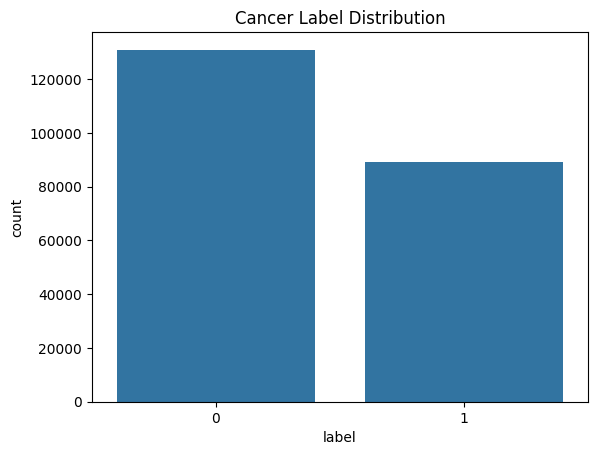

In [ ]:
#distributions
sns.countplot(x='label', data=labels)
plt.title("Cancer Label Distribution")
plt.show();

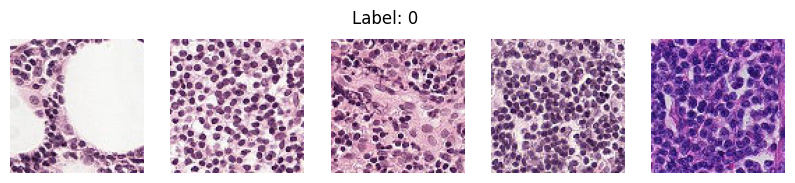

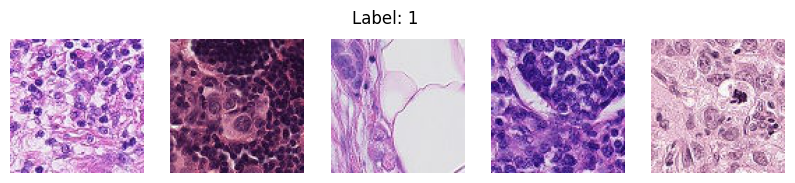

In [ ]:
#non-cancerous vs cancerous examples
def show_images(label_val):
    sample = labels[labels.label == label_val].sample(5)
    plt.figure(figsize=(10, 2))
    for i, img_id in enumerate(sample['id']):
        img = Image.open(os.path.join(train_dir, img_id + '.tif'))
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f"Label: {label_val}")
    plt.show()

show_images(0)
show_images(1)

In [ ]:
#preprocessing
labels['id'] = labels['id'] + '.tif'
labels['label'] = labels['label'].astype(str)

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_dataframe(
    labels, train_dir, x_col='id', y_col='label',
    target_size=(60, 60), class_mode='binary',
    batch_size=32, subset='training'
)

val_gen = datagen.flow_from_dataframe(
    labels, train_dir, x_col='id', y_col='label',
    target_size=(60, 60), class_mode='binary',
    batch_size=32, subset='validation'
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [6]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(60,60,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=[early_stop])

Epoch 1/10


/Users/tristanosborn/cancer-env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/tristanosborn/cancer-env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 125s 23ms/step - accuracy: 0.7601 - loss: 0.5032 - val_accuracy: 0.7951 - val_loss: 0.4441
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 123s 22ms/step - accuracy: 0.8029 - loss: 0.4368 - val_accuracy: 0.8091 - val_loss: 0.4228
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 127s 23ms/step - accuracy: 0.8155 - loss: 0.4144 - val_accuracy: 0.8292 - val_loss: 0.3856
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 129s 23ms/step - accuracy: 0.8300 - loss: 0.3889 - val_accuracy: 0.8402 - val_loss: 0.3648
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 132s 24ms/step - accuracy: 0.8389 - loss: 0.3702 - val_accuracy: 0.8368 - val_loss: 0.3744
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 127s 23ms/step - accuracy: 0.8474 - loss: 0.3530 - val_accuracy: 0.8418 - val_loss: 0.3611
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 129s 24ms/step - accuracy: 0.8550 - loss: 0.3387 - val_accuracy: 0.8552 - val_loss: 0.3350
Epoch 8/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 127s 23ms/step - accuracy: 0.8628 - lo

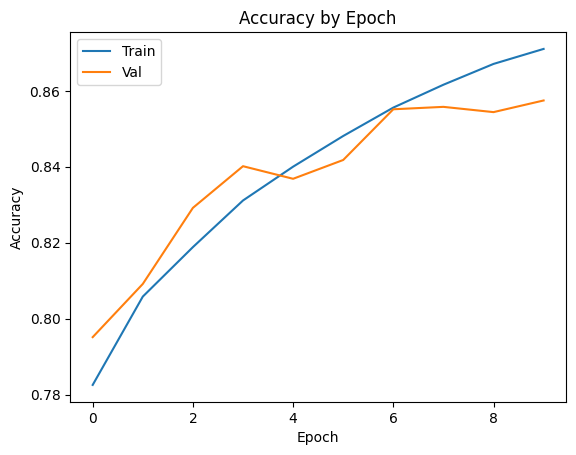

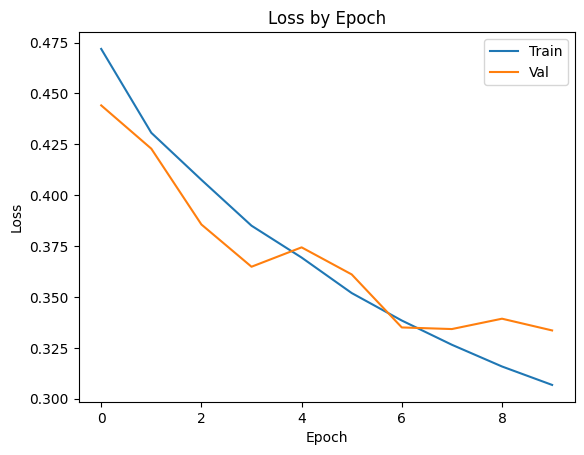

In [11]:
#accuracy and loss plots
def plot_metric(metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.title(f'{metric.title()} by Epoch')
    plt.xlabel('Epoch')
    plt.ylabel(metric.title())
    plt.legend(['Train', 'Val'])
    plt.show()

plot_metric('accuracy')
plot_metric('loss')

In [12]:
#test data preds
target_size = (60, 60)
test_files = os.listdir(test_dir)
test_df = pd.DataFrame({'id': test_files})

test_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    test_df, test_dir, x_col='id', y_col=None,
    target_size=target_size, batch_size=1, class_mode=None, shuffle=False
)

preds = model.predict(test_gen, steps=len(test_gen), verbose=1)
test_df['label'] = (preds > 0.5).astype(int)
test_df['id'] = test_df['id'].str.replace('.tif', '')
test_df.to_csv('submission.csv', index=False)

Found 57458 validated image filenames.
  273/57458 ━━━━━━━━━━━━━━━━━━━━ 31s 553us/step

/Users/tristanosborn/cancer-env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57458/57458 ━━━━━━━━━━━━━━━━━━━━ 30s 513us/step
